In [4]:
# Standard imports
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for imports
sys.path.insert(0, '..')

# Import rlgrid modules
from rlgrid import GridWorldEnv
from rlgrid import (
    uniform_policy,
    random_policy,
    random_deterministic_policy,
    policy_induced_transition_matrix,
    
)
from rlgrid import (
    simulate,
    visualize_grid,
)
from rlgrid.utils import (
    print_transition_info,
    print_policy_info,
    visualize_trajectory,
    compute_stationary_distribution,
)
from rlgrid.policies import policy_expected_reward

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Plot settings
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

print("Imports successful!")

Imports successful!


## 1. Loading and Visualizing Grid Environments

Grid environments are defined in `.txt` files using a simple format:
- `.` = free cell (traversable)
- `#` = wall (non-traversable)
- `G` = goal cell (unique in the grid)

In [5]:
# Load the simple 5x5 environment
env = GridWorldEnv.from_txt("../envs/gridworld.txt", rng=rng)

print("Grid layout:")
print(env)
print()
print(f"Environment: {env}")
print(f"Number of states: {env.n_states}")
print(f"Number of actions: {env.n_actions}")
print(f"Goal state: {env.goal_state}")
print(f"Goal position: {env.goal_pos}")
print(f"Grid size: {env.height} x {env.width}")

Grid layout:
##########
#........#
#....#...#
#....#...#
#....#...#
##.####.##
#...#....#
#...#....#
#...#....#
#...#....#
#.......G#
##########

Environment: ##########
#........#
#....#...#
#....#...#
#....#...#
##.####.##
#...#....#
#...#....#
#...#....#
#...#....#
#.......G#
##########
Number of states: 67
Number of actions: 4
Goal state: 66
Goal position: (10, 8)
Grid size: 12 x 10


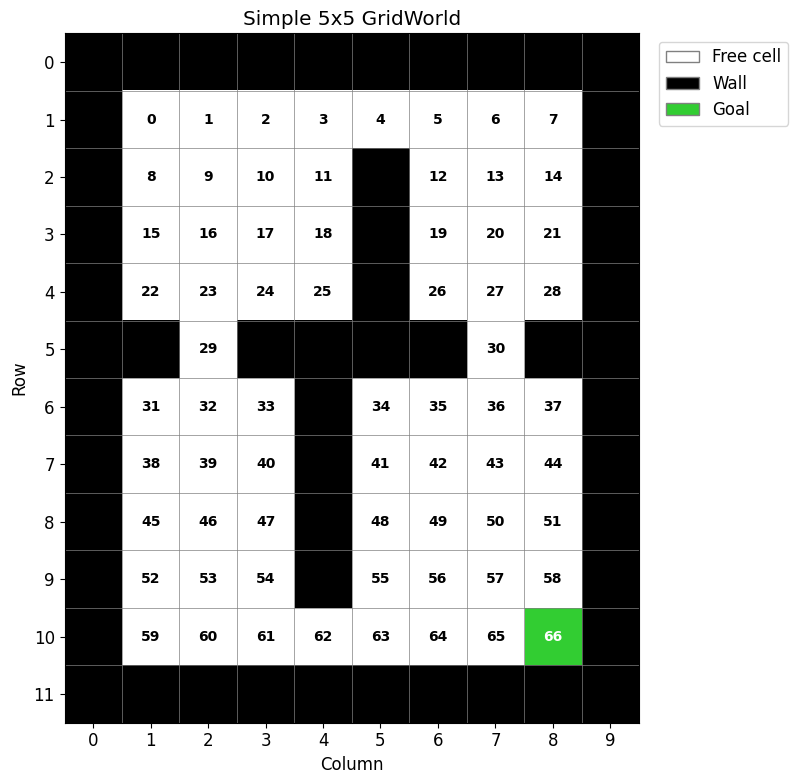

In [6]:
# Visualize the grid
fig, ax = plt.subplots(figsize=(8, 8))
visualize_grid(env, ax=ax, show_state_indices=True, title="Simple 5x5 GridWorld")
plt.tight_layout()
plt.show()

Maze layout:
##########
#........#
#.######.#
#.#....#.#
#.#.##.#.#
#.#.G#.#.#
#.#..#.#.#
#.####.#.#
#......#.#
##########

Number of states: 40
Goal state: 22 at position (5, 4)


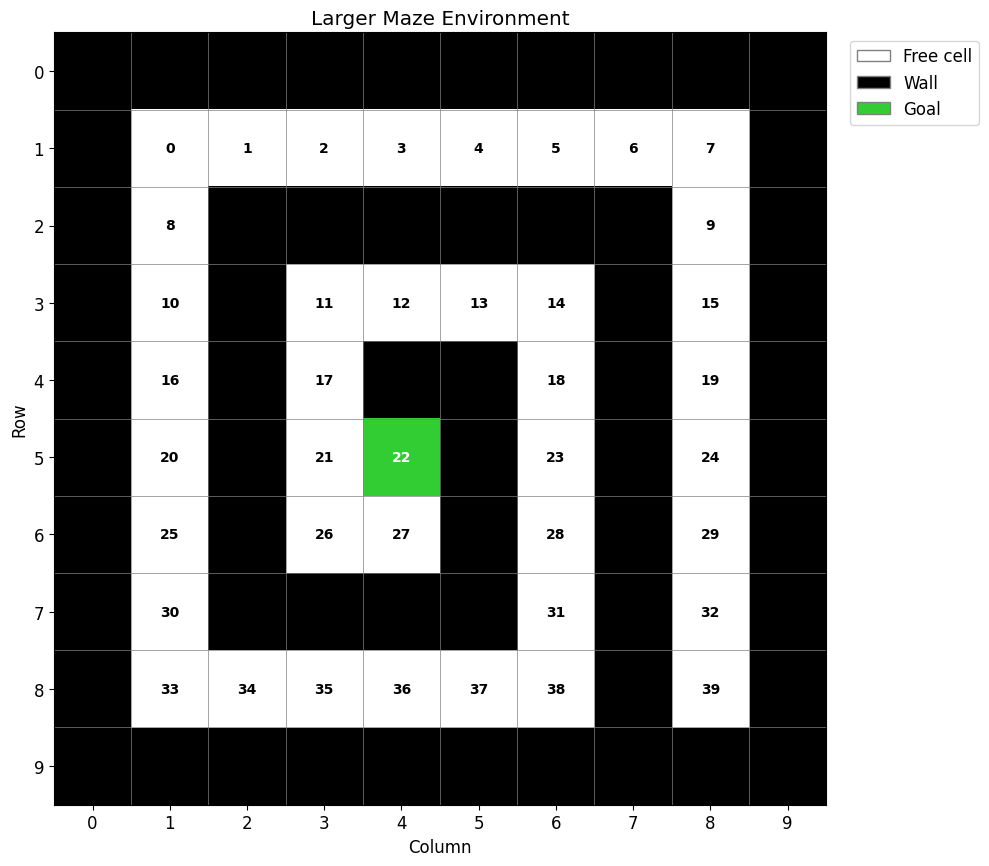

In [7]:
# Load and visualize a more complex environment
env_maze = GridWorldEnv.from_txt("../envs/larger_maze.txt", rng=rng)

print("Maze layout:")
print(env_maze)
print()
print(f"Number of states: {env_maze.n_states}")
print(f"Goal state: {env_maze.goal_state} at position {env_maze.goal_pos}")

fig, ax = plt.subplots(figsize=(10, 10))
visualize_grid(env_maze, ax=ax, show_state_indices=True, title="Larger Maze Environment")
plt.tight_layout()
plt.show()

In [8]:
# State-to-position mappings
print("State to Position mapping (simple 5x5):")
for state, pos in env.state_to_pos.items():
    goal_marker = " <- GOAL" if state == env.goal_state else ""
    print(f"  State {state}: position {pos}{goal_marker}")

State to Position mapping (simple 5x5):
  State 0: position (1, 1)
  State 1: position (1, 2)
  State 2: position (1, 3)
  State 3: position (1, 4)
  State 4: position (1, 5)
  State 5: position (1, 6)
  State 6: position (1, 7)
  State 7: position (1, 8)
  State 8: position (2, 1)
  State 9: position (2, 2)
  State 10: position (2, 3)
  State 11: position (2, 4)
  State 12: position (2, 6)
  State 13: position (2, 7)
  State 14: position (2, 8)
  State 15: position (3, 1)
  State 16: position (3, 2)
  State 17: position (3, 3)
  State 18: position (3, 4)
  State 19: position (3, 6)
  State 20: position (3, 7)
  State 21: position (3, 8)
  State 22: position (4, 1)
  State 23: position (4, 2)
  State 24: position (4, 3)
  State 25: position (4, 4)
  State 26: position (4, 6)
  State 27: position (4, 7)
  State 28: position (4, 8)
  State 29: position (5, 2)
  State 30: position (5, 7)
  State 31: position (6, 1)
  State 32: position (6, 2)
  State 33: position (6, 3)
  State 34: positi

## 2. Inspecting the Transition Kernel

The transition kernel `P[s, a, s']` gives the probability of transitioning to state `s'` when taking action `a` in state `s`.

Since our environment is **deterministic**, each `P[s, a, :]` has exactly one entry equal to 1.

In [9]:
# Get the transition kernel
P = env.get_transition_kernel()
print(f"Transition kernel shape: {P.shape}")
print(f"Expected: ({env.n_states}, {env.n_actions}, {env.n_states})")

Transition kernel shape: (67, 4, 67)
Expected: (67, 4, 67)


In [10]:
# Verify deterministic transitions: each (s, a) should have exactly one next state
print("Verifying deterministic transitions...")
is_deterministic = True
for s in range(env.n_states):
    for a in range(env.n_actions):
        n_nonzero = np.count_nonzero(P[s, a, :])
        if n_nonzero != 1:
            print(f"  State {s}, Action {a}: {n_nonzero} next states (should be 1)")
            is_deterministic = False

if is_deterministic:
    print("✓ All transitions are deterministic (exactly one next state per (s, a) pair)")

Verifying deterministic transitions...
✓ All transitions are deterministic (exactly one next state per (s, a) pair)


In [11]:
# Inspect transitions from a specific state
state_to_inspect = 0
print_transition_info(env, state_to_inspect)
print()

# Also inspect transitions from the goal state
print_transition_info(env, env.goal_state)

Transitions from state 0 at position (1, 1):
--------------------------------------------------
  up     -> state 0 at (1, 1) (stays in place - wall/boundary)
  right  -> state 1 at (1, 2) 
  down   -> state 8 at (2, 1) 
  left   -> state 0 at (1, 1) (stays in place - wall/boundary)

Transitions from state 66 at position (10, 8):
--------------------------------------------------
  up     -> state 58 at (9, 8) 
  right  -> state 66 at (10, 8) (GOAL! +1 reward, teleport)
  down   -> state 66 at (10, 8) (GOAL! +1 reward, teleport)
  left   -> state 65 at (10, 7) 


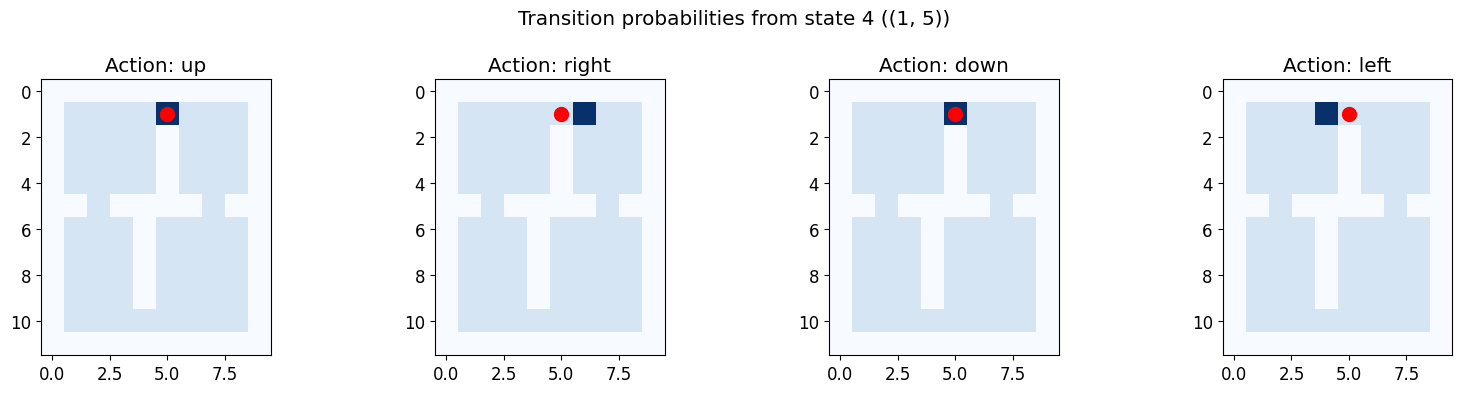

In [12]:
# Visualize transition probabilities for a specific state and action
state = 4  # Center state in simple 5x5

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle(f"Transition probabilities from state {state} ({env.state_to_pos[state]})")

for a, ax in enumerate(axes):
    # Reshape for visualization
    trans_probs = P[state, a, :]
    
    # Create a grid visualization
    grid_probs = np.zeros((env.height, env.width))
    for s_next, pos in env.state_to_pos.items():
        grid_probs[pos[0], pos[1]] = trans_probs[s_next]
    
    # Mark walls as -1 for visualization
    for r in range(env.height):
        for c in range(env.width):
            if env.grid[r][c] == '#':
                grid_probs[r, c] = -0.2
    
    im = ax.imshow(grid_probs, cmap='Blues', vmin=-0.2, vmax=1)
    ax.set_title(f"Action: {env.ACTIONS[a]}")
    
    # Mark the current state
    row, col = env.state_to_pos[state]
    ax.plot(col, row, 'ro', markersize=10)

plt.tight_layout()
plt.show()

## 3. Defining Policies

A policy π is a matrix of shape `(n_states, n_actions)` where `π[s, a]` is the probability of taking action `a` in state `s`.

We have three policy constructors:
1. **Uniform policy**: Equal probability for all actions
2. **Random policy**: Random stochastic policy
3. **Random deterministic policy**: One action per state, chosen randomly

In [13]:
# Create different policies
pi_uniform = uniform_policy(env)
pi_random = random_policy(env, rng=rng)
pi_det = random_deterministic_policy(env, rng=rng)

print("Uniform Policy (all actions equally likely):")
print(pi_uniform)
print()

print("Random Stochastic Policy:")
print(pi_random.round(3))
print()

print("Random Deterministic Policy:")
print(pi_det)

Uniform Policy (all actions equally likely):
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 

In [14]:
# Verify policies are valid (rows sum to 1)
print("Verifying policy validity...")
for name, pi in [("Uniform", pi_uniform), ("Random", pi_random), ("Deterministic", pi_det)]:
    row_sums = pi.sum(axis=1)
    all_valid = np.allclose(row_sums, 1.0)
    print(f"  {name}: rows sum to 1? {all_valid}")

Verifying policy validity...
  Uniform: rows sum to 1? True
  Random: rows sum to 1? True
  Deterministic: rows sum to 1? True


In [15]:
# Display detailed policy info
print_policy_info(env, pi_det)

Policy:
----------------------------------------------------------------------
 State   Position |       Up    Right     Down     Left
----------------------------------------------------------------------
     0     (1, 1) |    0.000    0.000    1.000    0.000
     1     (1, 2) |    1.000    0.000    0.000    0.000
     2     (1, 3) |    1.000    0.000    0.000    0.000
     3     (1, 4) |    1.000    0.000    0.000    0.000
     4     (1, 5) |    0.000    0.000    0.000    1.000
     5     (1, 6) |    1.000    0.000    0.000    0.000
     6     (1, 7) |    0.000    1.000    0.000    0.000
     7     (1, 8) |    0.000    0.000    1.000    0.000
     8     (2, 1) |    0.000    0.000    1.000    0.000
     9     (2, 2) |    0.000    0.000    1.000    0.000
    10     (2, 3) |    0.000    0.000    0.000    1.000
    11     (2, 4) |    0.000    1.000    0.000    0.000
    12     (2, 6) |    0.000    0.000    0.000    1.000
    13     (2, 7) |    0.000    1.000    0.000    0.000
    14    

In [16]:
# Compute policy-induced transition matrix
P_pi = policy_induced_transition_matrix(env, pi_uniform)

print(f"Policy-induced transition matrix shape: {P_pi.shape}")
print(f"Expected: ({env.n_states}, {env.n_states})")
print()

# Verify rows sum to 1
row_sums = P_pi.sum(axis=1)
print(f"Row sums: {row_sums.round(6)}")
print(f"All rows sum to 1? {np.allclose(row_sums, 1.0)}")

Policy-induced transition matrix shape: (67, 67)
Expected: (67, 67)

Row sums: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
All rows sum to 1? True


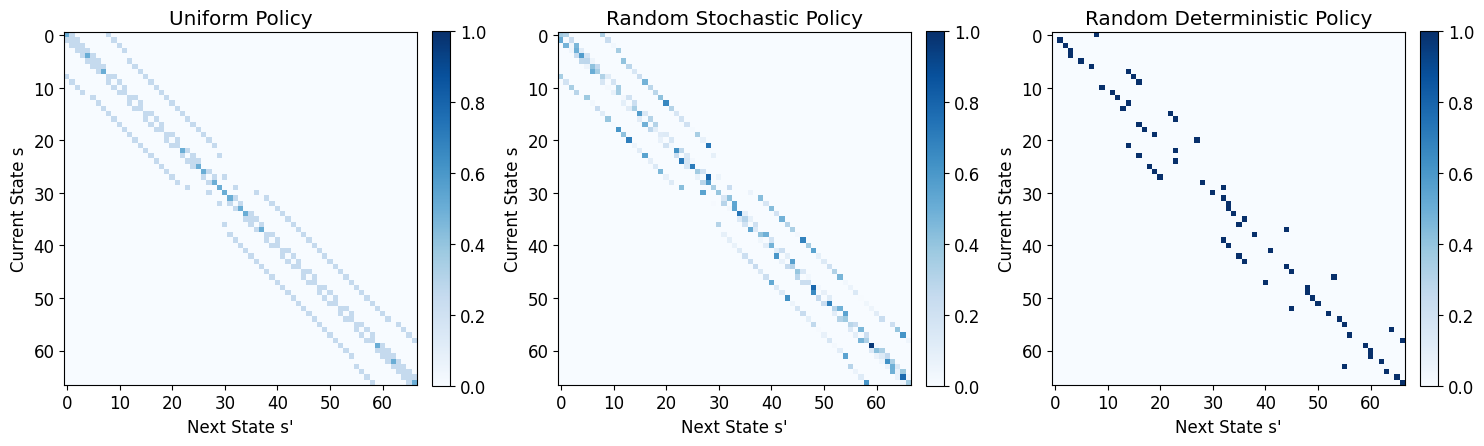

In [17]:
# Visualize policy-induced transition matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

policies = [
    ("Uniform Policy", pi_uniform),
    ("Random Stochastic Policy", pi_random),
    ("Random Deterministic Policy", pi_det),
]

for ax, (name, pi) in zip(axes, policies):
    P_pi = policy_induced_transition_matrix(env, pi)
    im = ax.imshow(P_pi, cmap='Blues', vmin=0, vmax=1)
    ax.set_title(name)
    ax.set_xlabel("Next State s'")
    ax.set_ylabel("Current State s")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 4. Simulating Trajectories

Let's run simulations in the environment under different policies.

In [18]:
# Short simulation for demonstration
T_short = 20
states, actions, rewards = simulate(env, pi_uniform, T=T_short, start_state=0, rng=rng)

print(f"Simulation for {T_short} steps under uniform policy:")
print(f"  States visited: {states}")
print(f"  Actions taken: {actions}")
print(f"  Rewards received: {rewards}")
print()
print(f"  Total reward: {rewards.sum()}")
print(f"  Average reward: {rewards.mean():.4f}")

# Check for goal visits
goal_visits = np.sum(rewards == 1)
print(f"  Goal reached {goal_visits} times")

Simulation for 20 steps under uniform policy:
  States visited: [ 0  0  1  2 10 11  3  4  5  5  6  7  7  7 14 14 13 12 13 14 21]
  Actions taken: [3 1 1 2 1 0 1 1 0 1 1 1 1 2 1 3 3 1 1 2]
  Rewards received: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]

  Total reward: -20.0
  Average reward: -1.0000
  Goal reached 0 times


In [19]:
# Demonstrate teleportation from goal
print("Demonstrating teleportation from goal:")
print()

# Find when we hit the goal
for t in range(len(rewards)):
    if rewards[t] == 1:
        s = states[t]
        a = actions[t]
        s_next = states[t + 1]
        
        print(f"  Step {t}: State {s} -> Action {env.ACTIONS[a]} -> "
              f"Goal reached! (reward +1) -> Teleported to state {s_next}")
        print(f"           Position {env.state_to_pos[s]} -> {env.state_to_pos[s_next]}")

Demonstrating teleportation from goal:



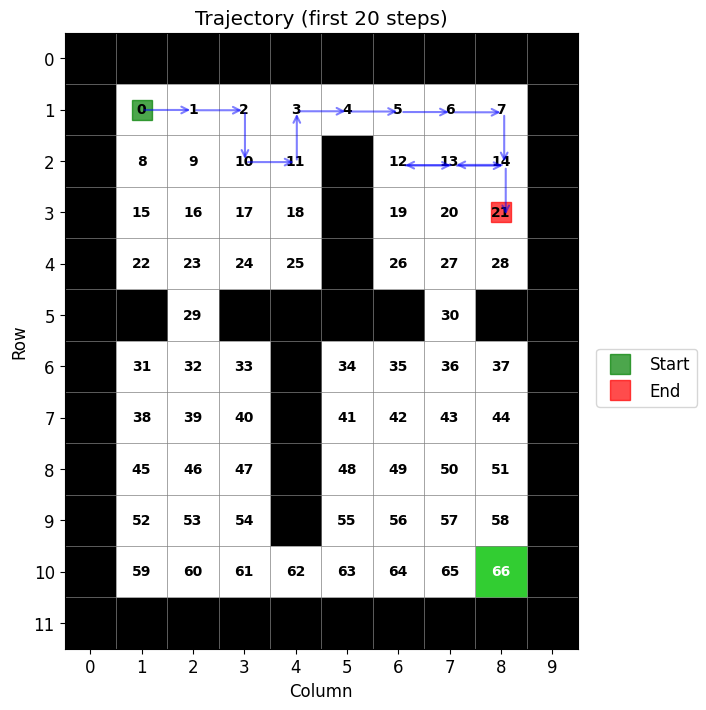

In [20]:
# Visualize a short trajectory
visualize_trajectory(env, states, max_steps=30)
plt.show()

In [21]:
def average_reward_value(P, r, phi):
    """
    Solve for (v, rho) in the average-reward setting with normalization phi^T v = 0.

    Assumptions:
      - P is (n, n) transition matrix for a fixed policy.
      - r is (n,) reward vector.
      - phi is (n,) probability vector, typically the stationary distribution of P,
        so that phi^T P = phi^T and phi^T 1 = 1.

    Returns:
      v   : differential value function (n,)
      rho : average reward (scalar)
    """
    P = np.asarray(P, dtype=float)
    r = np.asarray(r, dtype=float)
    phi = np.asarray(phi, dtype=float)

    n = r.shape[0]
    I = np.eye(n)
    ones = np.ones((n, 1))

    # Average reward: rho = phi^T r
    rho = np.dot(phi, r)

    # Centered reward: r - rho * 1
    rhs = r - rho  # broadcasts rho to all components

    # Solve (I - P + 1 phi^T) v = r - rho * 1
    A = I - P + ones @ phi.reshape(1, -1)
    v = np.linalg.solve(A, rhs)

    return v, rho

In [ ]:
error_diffs = []

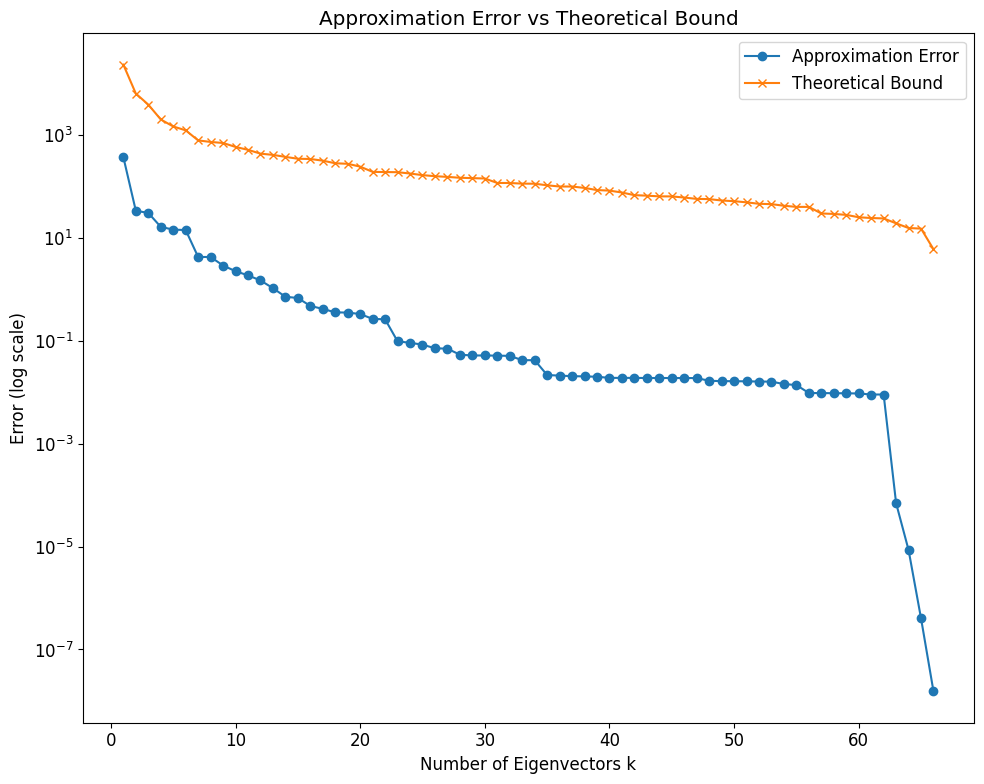

In [ ]:
rng = np.random.default_rng(2382)
pi_random = random_policy(env, rng=rng)

P_pi = policy_induced_transition_matrix(env, pi_random)
phi = compute_stationary_distribution(P_pi)
Phi = np.diag(phi)
r = policy_expected_reward(env, pi_random)
v_true = average_reward_value(P_pi, r, phi)[0]
dash_r = r - np.dot(phi,r)
L = Phi - (Phi@P_pi + P_pi.T@Phi)/2
val, eig = np.linalg.eig(L)
# sort the eigenvalues and eigenvectors
idx = val.argsort()
val = val[idx]
eig = eig[:, idx]
def compute_error(k: int) -> float:
    val, eig = np.linalg.eig(L)
    # sort the eigenvalues and eigenvectors
    idx = val.argsort()
    val = val[idx]
    eig = eig[:, idx]
    Z = eig[: ,:k]
    approx_v = Z @ (np.linalg.inv(Z.T @ Z) @ Z.T) @ v_true
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LinearRegression
    pipe = Pipeline([
        ('regressor', LinearRegression(fit_intercept=False))
    ])
    pipe.fit(Z, v_true)
    return np.linalg.norm(pipe.predict(Z) - v_true)**2
def phi_norm(v: np.ndarray, phi: np.ndarray) -> float:
    return np.linalg.norm(phi*v)


norm_r = np.linalg.norm(r)
theoretical_bound = [phi_norm(dash_r,phi)**2/(val[1]*val[k]) for k in range(1,len(val))]
# plot the error and the theoretical bound
ks = np.arange(1, len(val))
errors = [compute_error(k) for k in ks]
dif = errors - theoretical_bound